In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

In [2]:
result_dir = '../results/dfvdvf/'

In [3]:
# Load the results
files_to_read = [file for file in os.listdir(result_dir) if file.endswith('.csv')]

In [4]:
pattern = r'agent_stats_run_(\d+)_ctr_0.97_alpha_(\d+\.?\d*)'
files_per_alpha = {}
for file in files_to_read:
    match = re.search(pattern, file)
    if match:
        alpha = float(match.group(2))
        if alpha not in files_per_alpha:
            files_per_alpha[alpha] = [file]
        else:
            files_per_alpha[alpha].append(file)

In [5]:
# Load the results
results = pd.DataFrame()
for alpha, files in files_per_alpha.items():
    for file in files:
        curr_results = pd.read_csv(result_dir + file)
        curr_results['alpha'] = alpha
        results = pd.concat([results, curr_results])

## carico risultati CUCB

In [8]:
grouped_cucb_results = pd.read_csv('../results/FP_Truthful_Oracle_sigmoids_cucb_est_click_impr/grouped_results_iter.csv')

In [57]:
cucb_result_dir = '../results/FP_Truthful_Oracle_sigmoids_cucb_est_click_impr_alphatune/'
# Load the results
cucb_files_to_read = [file for file in os.listdir(cucb_result_dir) if file.endswith('.csv')]
pattern = r'agent_stats_run_(\d+)_ctr_0.97_alpha_(\d+\.?\d*)'
cucb_files_per_alpha = {}
for file in cucb_files_to_read:
    match = re.search(pattern, file)
    if match:
        alpha = float(match.group(2))
        if alpha not in cucb_files_per_alpha:
            cucb_files_per_alpha[alpha] = [file]
        else:
            cucb_files_per_alpha[alpha].append(file)

In [58]:
# Load the results
cucb_results = pd.DataFrame()
for alpha, files in cucb_files_per_alpha.items():
    for file in files:
        curr_cucb_results = pd.read_csv(cucb_result_dir + file)
        curr_cucb_results['alpha'] = alpha
        cucb_results = pd.concat([cucb_results, curr_cucb_results])

## raggruppo dati cucb

In [59]:
# Prima raggruppo per Run e Iteration per avere il dato aggregato per ogni iterazione
grouped_cucb_results_run_iter = cucb_results.groupby(['alpha', 'Run', 'Iteration']) \
    .agg({'clicks': 'sum', 'impressions': 'sum', 'true_clicks': 'sum'}) \
    .reset_index()
grouped_cucb_results = grouped_cucb_results_run_iter.groupby(['alpha', 'Iteration']).mean().reset_index()

In [60]:
grouped_cucb_results['ctr'] = grouped_cucb_results['clicks'] / grouped_cucb_results['impressions']
grouped_cucb_results['true_ctr'] = grouped_cucb_results['true_clicks'] / grouped_cucb_results['impressions']

In [61]:
unique_alphas_cucb = grouped_cucb_results['alpha'].unique()

### aggiungo esperimenti con alpha 0.2 (100 run e 100 iterazioni)

In [6]:
alpha_02_dir = '../results/FP_Truthful_Oracle_sigmoids_linucb_est_click_impr/'
files_to_read_02 = [file for file in os.listdir(alpha_02_dir) if file.endswith('.csv')]
results_a_02 = pd.DataFrame()
for file in files_to_read_02:
    curr_results = pd.read_csv(alpha_02_dir + file)
    curr_results['alpha'] = 0.2
    results_a_02 = pd.concat([results_a_02, curr_results])
# aggiungo i risultati con alpha 0.2 a results
results = pd.concat([results, results_a_02])

In [7]:
# Prima raggruppo per Run e Iteration per avere il dato aggregato per ogni iterazione
grouped_results_run_iter = results.groupby(['alpha', 'Run', 'Iteration']) \
    .agg({'clicks': 'sum', 'impressions': 'sum', 'true_clicks':'sum'}) \
    .reset_index()

In [9]:
grouped_results_iter = grouped_results_run_iter.groupby(['alpha', 'Iteration']).mean().reset_index()

In [10]:
unique_alphas = grouped_results_iter['alpha'].unique()

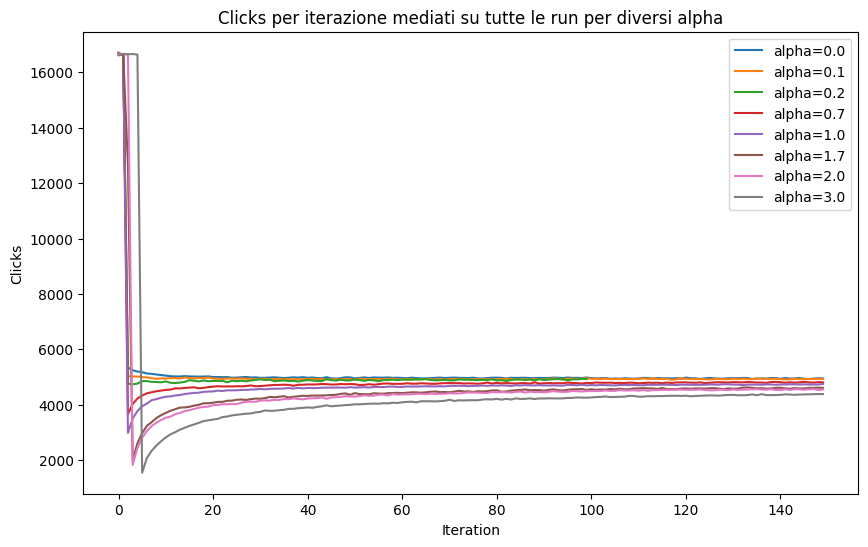

In [11]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[grouped_results_iter['alpha'] == alpha]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['clicks'].to_numpy(), label=f'alpha={alpha}')

plt.title('Clicks per iterazione mediati su tutte le run per diversi alpha')
plt.xlabel('Iteration')
plt.ylabel('Clicks')
plt.legend()
plt.show()

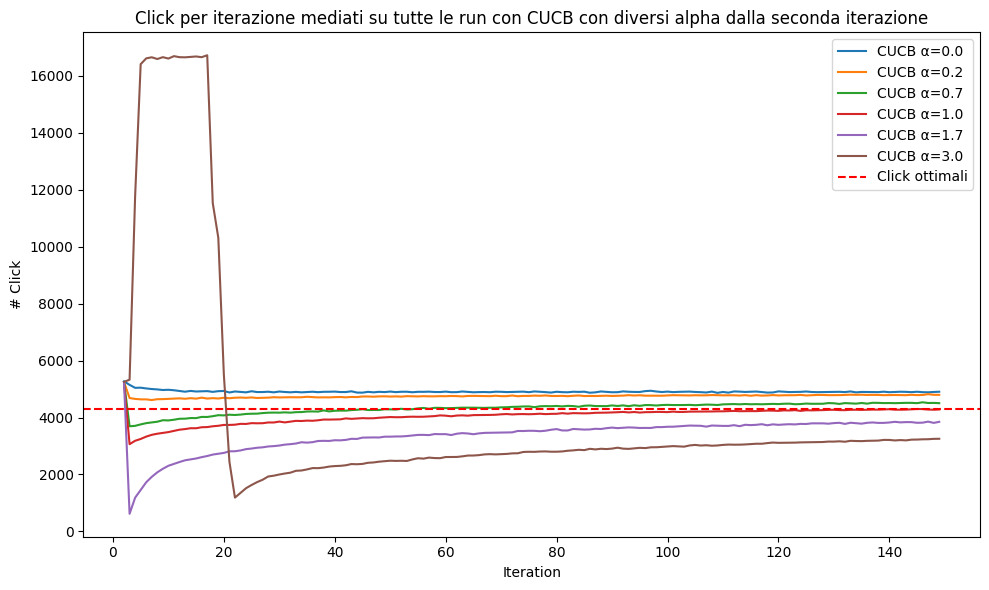

In [62]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas_cucb:
    alpha_data = grouped_cucb_results[(grouped_cucb_results['Iteration']>1)&(grouped_cucb_results['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['clicks'].to_numpy(), label=f'CUCB α={alpha}')
plt.axhline(y=4312, color='r', linestyle='--', label='Click ottimali')
plt.title('Click per iterazione mediati su tutte le run con CUCB con diversi alpha dalla seconda iterazione')
plt.xlabel('Iteration')
plt.ylabel('# Click')
plt.legend()
plt.tight_layout()
plt.show()

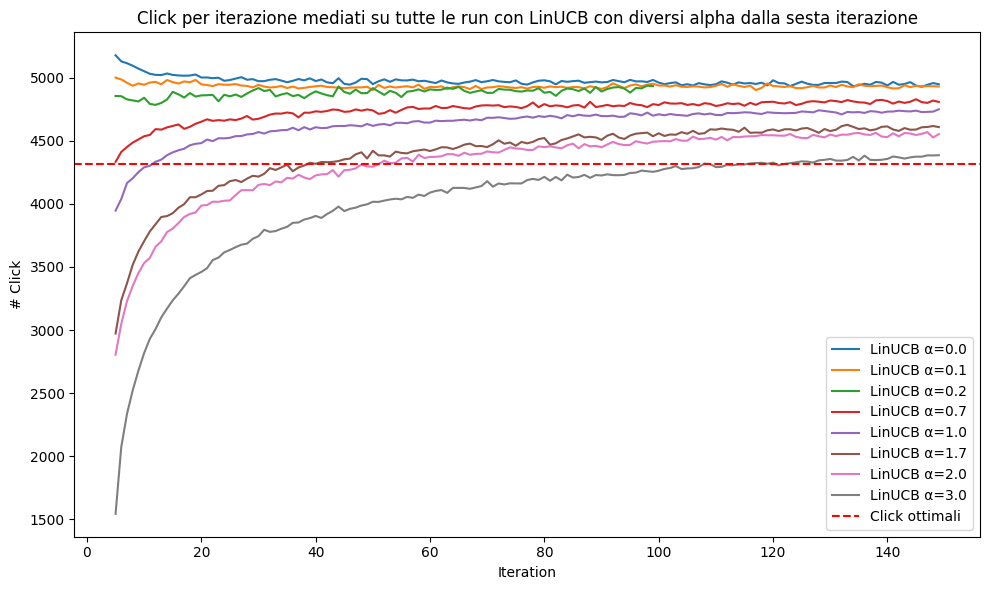

In [56]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>4)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['clicks'].to_numpy(), label=f'LinUCB α={alpha}')
plt.axhline(y=4312, color='r', linestyle='--', label='Click ottimali')
plt.title('Click per iterazione mediati su tutte le run con LinUCB con diversi alpha dalla sesta iterazione')
plt.xlabel('Iteration')
plt.ylabel('# Click')
plt.legend()
plt.tight_layout()
plt.show()

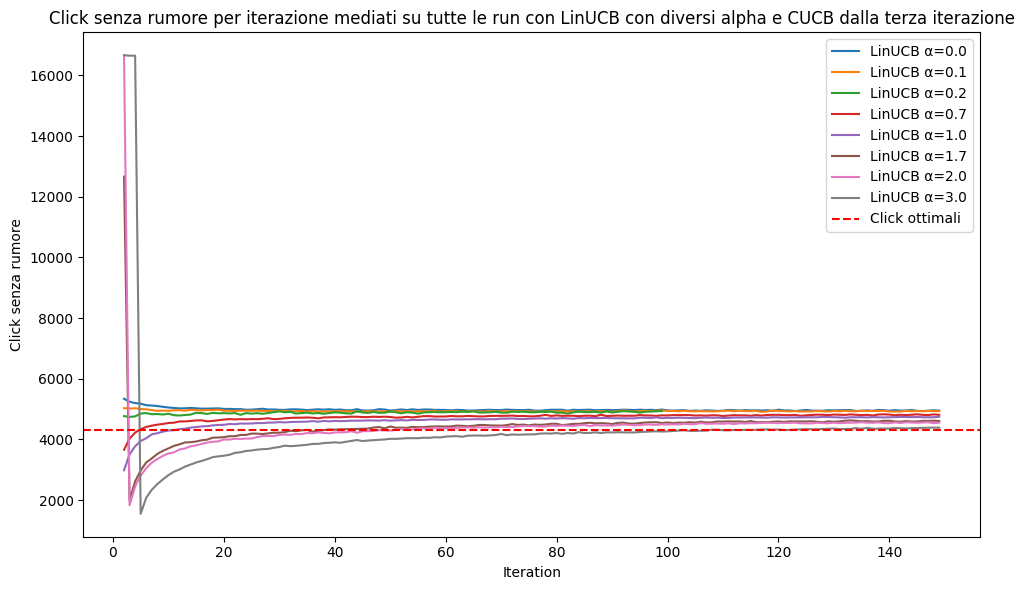

In [48]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>1)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['true_clicks'].to_numpy(), label=f'LinUCB α={alpha}')
plt.axhline(y=4312, color='r', linestyle='--', label='Click ottimali')
plt.title('Click senza rumore per iterazione mediati su tutte le run con LinUCB con diversi alpha e CUCB dalla terza iterazione')
plt.xlabel('Iteration')
plt.ylabel('Click senza rumore')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Errore tra il numero di click e il numero di click senza rumore
grouped_results_iter['click_error'] = np.abs(grouped_results_iter['clicks'] - grouped_results_iter['true_clicks'])
grouped_results_iter['click_percentage_error'] = (grouped_results_iter['click_error'] / grouped_results_iter['true_clicks']) * 100

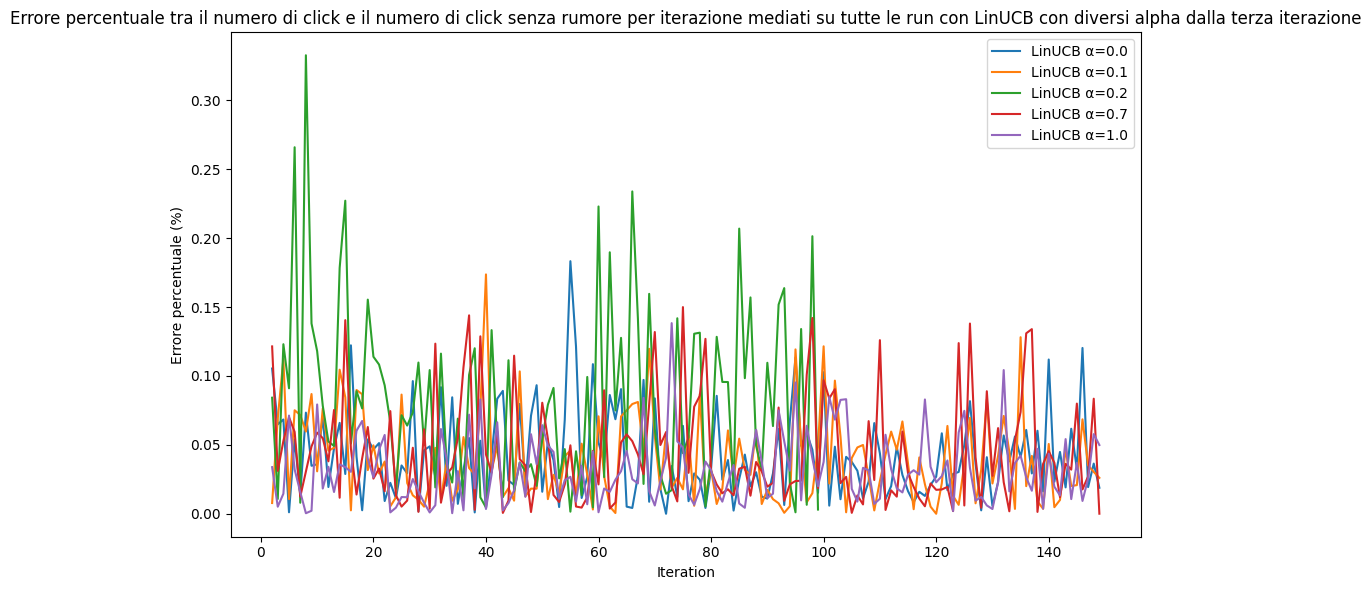

In [62]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>1)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['click_percentage_error'].to_numpy(), label=f'LinUCB α={alpha}')
plt.title('Errore percentuale tra il numero di click e il numero di click senza rumore per iterazione mediati su tutte le run con LinUCB con diversi alpha dalla terza iterazione')
plt.xlabel('Iteration')
plt.ylabel('Errore percentuale (%)')
plt.legend()
plt.tight_layout()
plt.show()

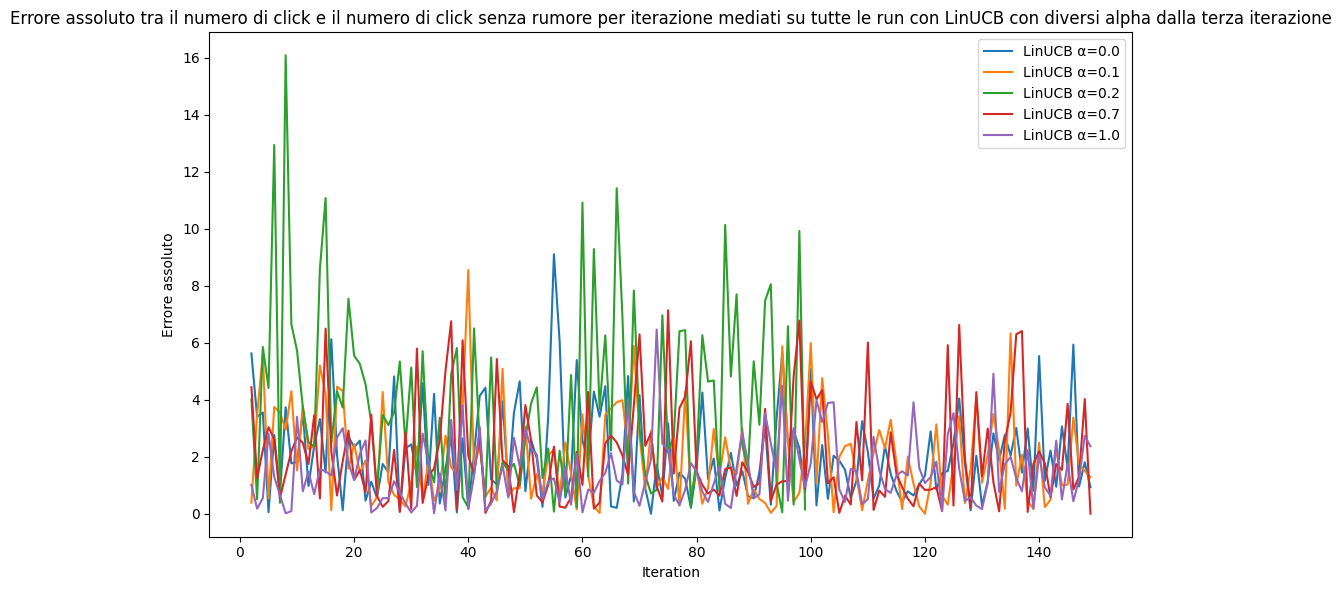

In [63]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>1)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['click_error'].to_numpy(), label=f'LinUCB α={alpha}')
plt.title('Errore assoluto tra il numero di click e il numero di click senza rumore per iterazione mediati su tutte le run con LinUCB con diversi alpha dalla terza iterazione')
plt.xlabel('Iteration')
plt.ylabel('Errore assoluto')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
grouped_results_iter['ctr'] = grouped_results_iter['clicks'] / grouped_results_iter['impressions']
grouped_results_iter['true_ctr'] = grouped_results_iter['true_clicks'] / grouped_results_iter['impressions']

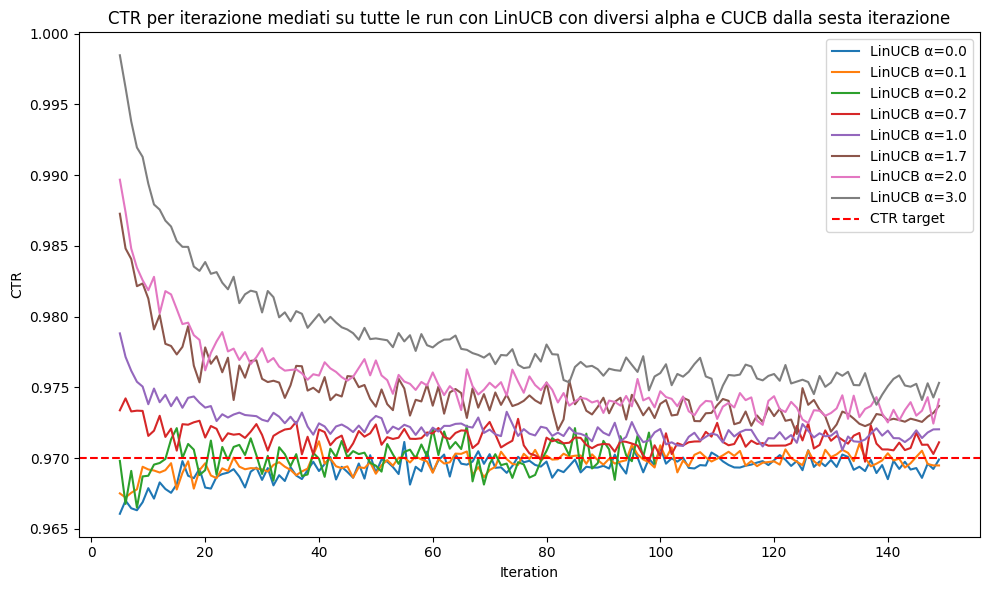

In [49]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>4)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['ctr'].to_numpy(), label=f'LinUCB α={alpha}')
plt.axhline(y=0.97, color='r', linestyle='--', label='CTR target')
plt.title('CTR per iterazione mediati su tutte le run con LinUCB con diversi alpha e CUCB dalla sesta iterazione')
plt.xlabel('Iteration')
plt.ylabel('CTR')
plt.legend()
plt.tight_layout()
plt.show()

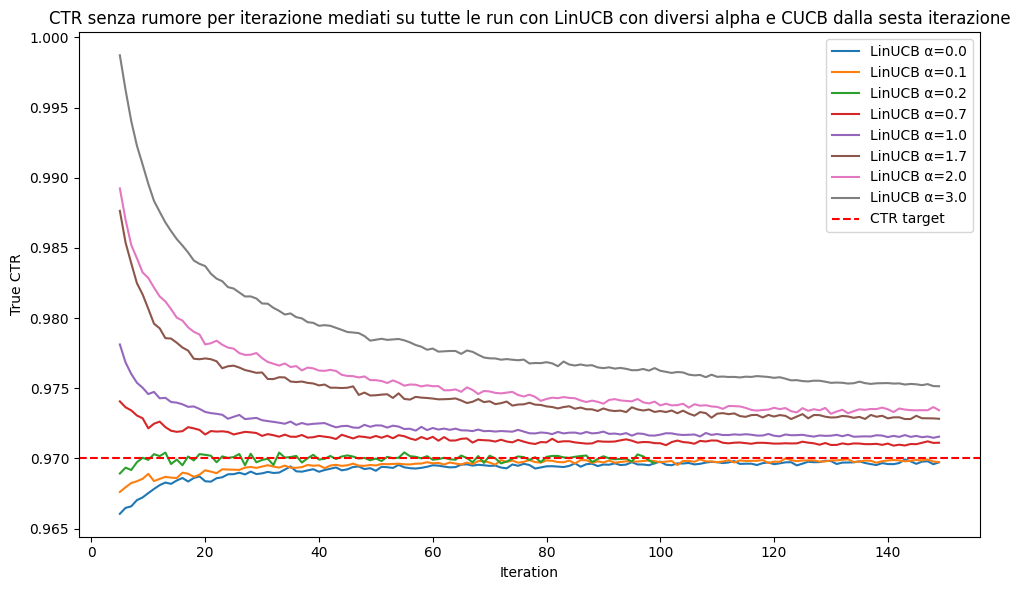

In [50]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas:
    alpha_data = grouped_results_iter[(grouped_results_iter['Iteration']>4)&(grouped_results_iter['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['true_ctr'].to_numpy(), label=f'LinUCB α={alpha}')
plt.axhline(y=0.97, color='r', linestyle='--', label='CTR target')
plt.title('CTR senza rumore per iterazione mediati su tutte le run con LinUCB con diversi alpha e CUCB dalla sesta iterazione')
plt.xlabel('Iteration')
plt.ylabel('True CTR')
plt.legend()
plt.tight_layout()
plt.show()

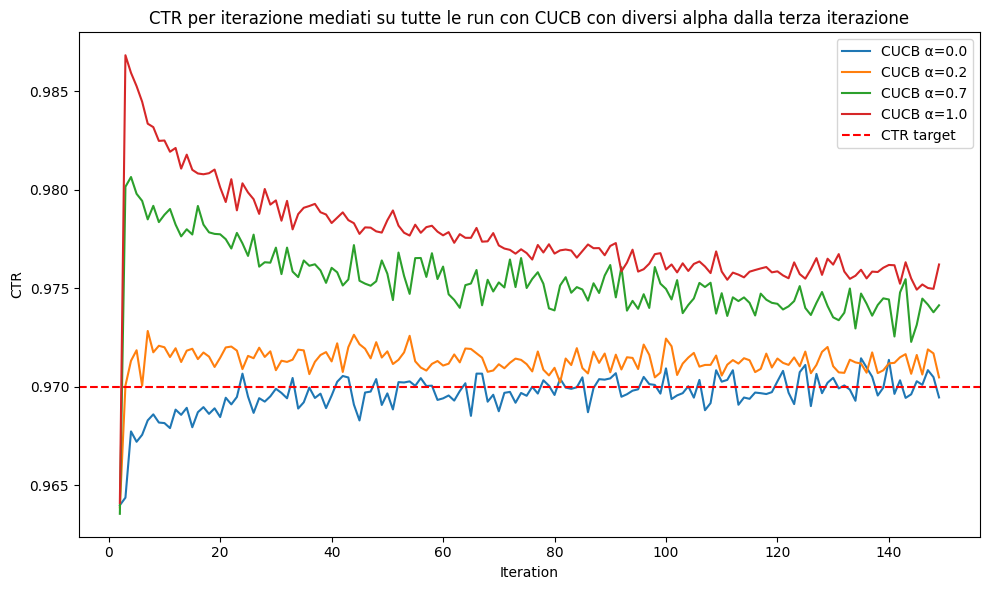

In [53]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas_cucb:
    alpha_data = grouped_cucb_results[(grouped_cucb_results['Iteration']>1)&(grouped_cucb_results['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['ctr'].to_numpy(), label=f'CUCB α={alpha}')
plt.axhline(y=0.97, color='r', linestyle='--', label='CTR target')
plt.title('CTR per iterazione mediati su tutte le run con CUCB con diversi alpha dalla terza iterazione')
plt.xlabel('Iteration')
plt.ylabel('CTR')
plt.legend()
plt.tight_layout()
plt.show()

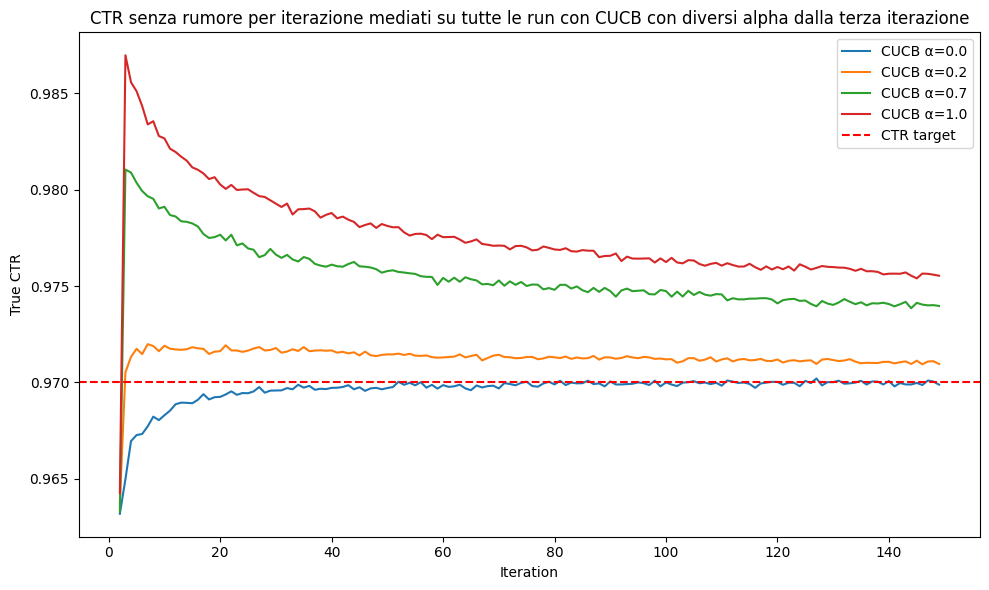

In [54]:
plt.figure(figsize=(10, 6))
for alpha in unique_alphas_cucb:
    alpha_data = grouped_cucb_results[(grouped_cucb_results['Iteration']>1)&(grouped_cucb_results['alpha'] == alpha)]
    plt.plot(alpha_data['Iteration'].to_numpy(), alpha_data['true_ctr'].to_numpy(), label=f'CUCB α={alpha}')
plt.axhline(y=0.97, color='r', linestyle='--', label='CTR target')
plt.title('CTR senza rumore per iterazione mediati su tutte le run con CUCB con diversi alpha dalla terza iterazione')
plt.xlabel('Iteration')
plt.ylabel('True CTR')
plt.legend()
plt.tight_layout()
plt.show()

## Calcolo il numero di click ottimo che si dovrebbe raggiungere

In [123]:
import numpy as np
from ortools.linear_solver import pywraplp

In [124]:
def get_data(
        df: pd.DataFrame,
):
    # Estraggo i dati dal dataframe
    n = df.shape[0]
    clicks = df['clicks'].values
    impressions = df['impressions'].values
    spent = df['spent'].values
    return n, clicks, impressions, spent

In [125]:
def solver(
        df: pd.DataFrame,
        n: int,
        clicks: np.ndarray = None,
        impressions: np.ndarray = None,
        spent: np.ndarray = None,
        cpc: np.ndarray = None,
        soglia_spent: float = None,
        soglia_clicks: float = None,
        soglia_cpc: float = None,
        soglia_ctr: float = None,
        soglia_num_publisher: int = None,
):
    # Inizializzo il solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Definisco le variabili
    x = [solver.BoolVar(f'x{i}') for i in range(n)]
    x_np = np.array(x)
    # Funzione obiettivo
    solver.Maximize(np.dot(clicks, x_np))
    if soglia_clicks is not None:
        # Vincolo Clicks
        solver.Add(np.dot(clicks, x_np) >= soglia_clicks)
    if soglia_spent is not None:
        # Vincolo Spesa
        solver.Add(np.dot(spent, x_np) <= soglia_spent)
    if soglia_cpc is not None:
        # Vincolo CPC
        solver.Add(np.dot(cpc, x_np) <= soglia_cpc)
    if soglia_ctr is not None:
        # Vincolo CTR
        solver.Add(np.dot(clicks, x_np) >= soglia_ctr * np.dot(impressions, x_np))
    if soglia_num_publisher is not None:
        # Vincolo Numero Publisher
        solver.Add(sum(x_np) <= soglia_num_publisher)
    # Risolvo il problema
    status = solver.Solve()
    results = pd.DataFrame(columns=df.columns)
    # Output dei risultati
    if status == pywraplp.Solver.OPTIMAL:
        for i in range(n):
            if x[i].solution_value() == 1:
                if results.empty:
                    results = df.iloc[[i]]
                else:
                    results = pd.concat([results, df.iloc[[i]]])
        print("Knapsack Solver: Soluzione ottimale trovata!")
        print(f"Valore obiettivo = {round(solver.Objective().Value(), 3)}")
        impressions_sum = results['impressions'].sum()
        if impressions_sum != 0:
            print(f"CTR = {round(results['clicks'].sum() / impressions_sum * 100, 3)}%")
        else:
            print(f"CTR = {0}%")
    else:
        print("Knapsack Solver: Non è stata trovata una soluzione ottimale.")
        # Return empty dataframe
        return pd.DataFrame()
    return results

### Carico i dati medi su click e impression di tutti i publisher

In [126]:
mean_results = pd.read_csv('../results/FP_Truthful_Oracle_sigmoids_1run1pub/mean_results.csv')

In [170]:
pub_to_look = results[results['Iteration']==0]['publisher'].unique()

In [171]:
mean_stats = mean_results[mean_results['publisher'].isin(pub_to_look)]

In [172]:
n, clicks, impressions, spent = get_data(mean_stats)

In [173]:
soglia_ctr = 0.97
results = solver(
    mean_stats,
    n,
    clicks=clicks,
    impressions=impressions,
    soglia_ctr=soglia_ctr,
)

Knapsack Solver: Soluzione ottimale trovata!
Valore obiettivo = 4312.86
CTR = 97.001%


In [174]:
opt_ctr = results['clicks'].sum() / results['impressions'].sum()
opt_clicks = results['clicks'].sum()
print(f"CTR ottimale = {opt_ctr}")
print(f"Clicks ottimali = {opt_clicks}")

CTR ottimale = 0.970008164256749
Clicks ottimali = 4312.86


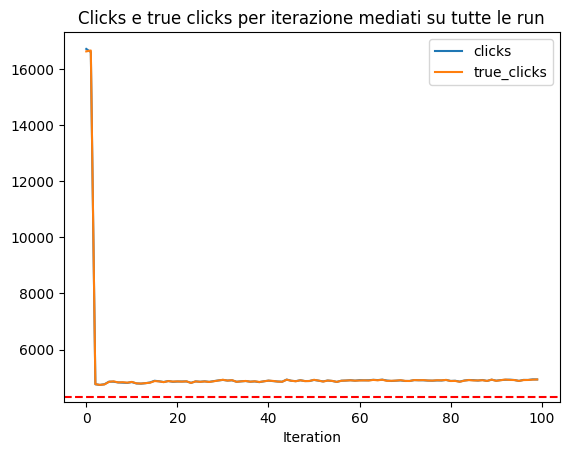

In [175]:
grouped_results_iter.plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run')
plt.axhline(y=opt_clicks, color='r', linestyle='--')
plt.show()

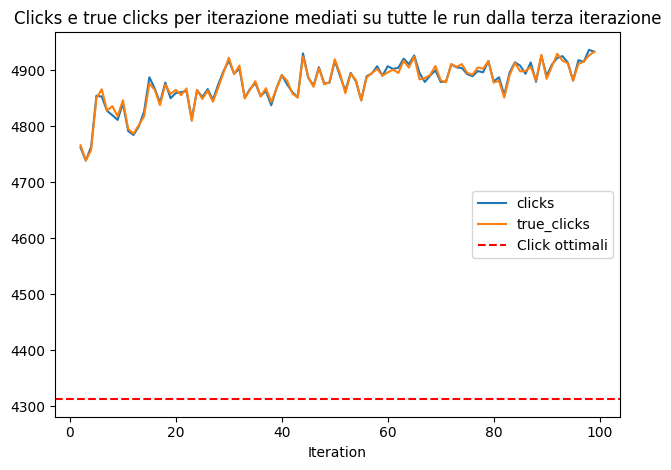

In [176]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run dalla terza iterazione')
plt.axhline(y=opt_clicks, color='r', linestyle='--', label='Click ottimali')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
from collections import deque

In [28]:
struct_d = deque(maxlen=5)

In [29]:
for i in range(3):
    struct_d.append(i)
    print(struct_d)

deque([0], maxlen=5)
deque([0, 1], maxlen=5)
deque([0, 1, 2], maxlen=5)


In [33]:
len(struct_d)

3